Trial 30 Complete [00h 02m 30s]
val_accuracy: 0.33649998903274536

Best val_accuracy So Far: 0.34312498569488525
Total elapsed time: 00h 35m 22s

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 256 and the optimal learning rate for the optimizer
is 0.001.


🧠 Training the best model found by the tuner...
Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.3382 - loss: 1.1738 - val_accuracy: 0.3266 - val_loss: 1.1015 - learning_rate: 0.0010
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.3380 - loss: 1.0999 - val_accuracy: 0.3359 - val_loss: 1.0994 - learning_rate: 0.0010
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.3365 - loss: 1.0991 - val_accuracy: 0.3332 - val_loss: 1.0994 - learning_rate: 0.0010
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.3382 - loss: 1.0983 - val_accuracy: 0.3320 - val_loss: 1.0994 - learning_rate: 0.0010
Epoch 5/100
313/313

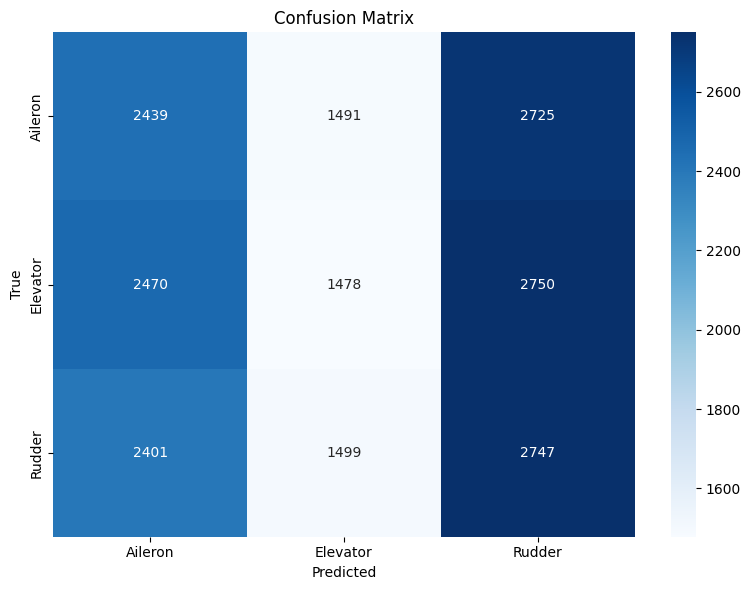

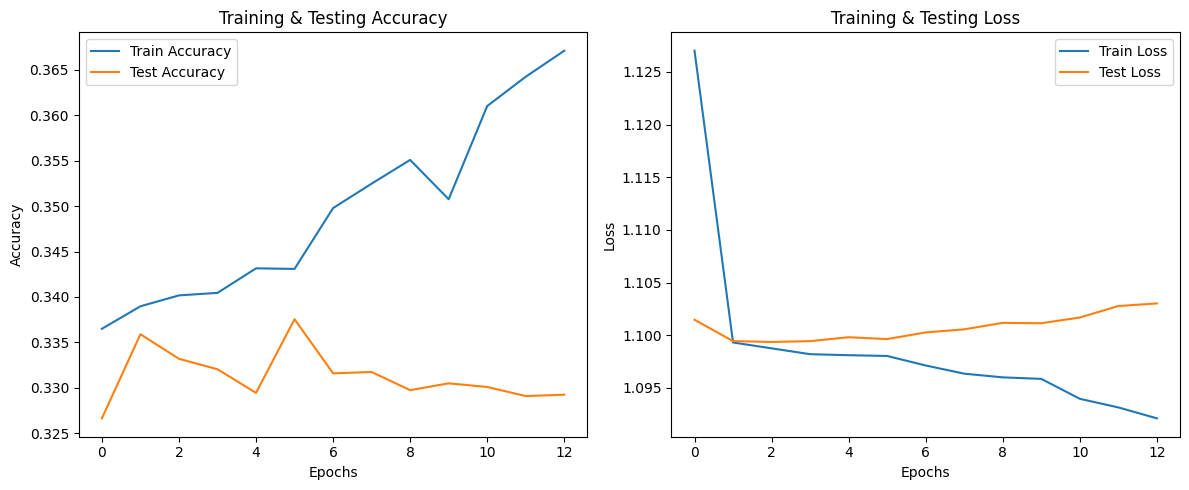

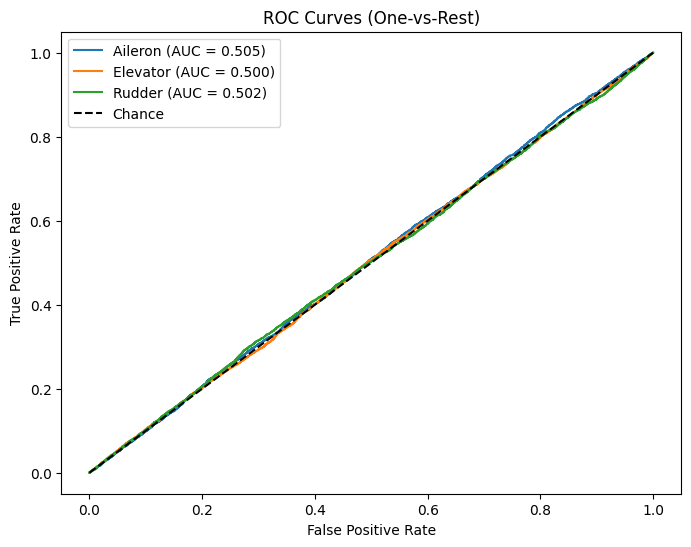


=== Part 2: Regression for Damping Ratio & Natural Frequency (CNN) ===


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_5 (Conv1D)               │ (None, 9, 64)          │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 9, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 4, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 4, 128)         │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 4, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 2, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,882 (230.01 KB)

 Trainable params: 58,498 (228.51 KB)

 Non-trainable params: 384 (1.50 KB)


🧠 Training the regression model...


KeyError: "None of [Index([10556, 66159, 99443, 43836, 27208, 63683,  4185, 22987, 29221,  8487,\n       ...\n       53177, 60972, 62570, 19713, 22305, 65288, 62396, 13996,  7091, 40168],\n      dtype='int64', length=20000)] are in the [index]"

In [4]:
# =======================================================
# Phase 2.1 – CNN (Convolutional Neural Network) Pipeline
# =======================================================

# --- 1. Imports ---
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import files
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_curve, auc,
    mean_squared_error, mean_absolute_error
)
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import label_binarize

import tensorflow as tf
from tensorflow.keras import Sequential, layers, Model, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback

# Keras Tuner for hyperparameter optimization
try:
    import keras_tuner as kt
except ImportError:
    !pip install -q keras-tuner
    import keras_tuner as kt


np.random.seed(42)
tf.random.set_seed(42)

# --- 2. Upload Dataset ---
print("📂 Please upload control_surface_vibrations_80k.csv")
uploaded = files.upload()
FILE_PATH = list(uploaded.keys())[0]

df = pd.read_csv(FILE_PATH)
print("Dataset shape:", df.shape)
print(df.head())


# --- 3. Preprocessing ---
CAT_FEATURES = ["Material"]
TARGET_COL_CLASS = "Surface_Type"
TARGET_COLS_REG = ["Damping_Ratio", "Natural_Freq_Hz"]

df = df.drop_duplicates().dropna().reset_index(drop=True)

# --- Part 1: Classification Task ---
print("\n=== Part 1: Surface Type Classification (CNN) ===")

# Define features (X) and target (y)
X = df.drop(columns=[TARGET_COL_CLASS] + TARGET_COLS_REG)
y = df[TARGET_COL_CLASS]

# Encode target labels
le = LabelEncoder()
y_int = le.fit_transform(y)
CLASS_NAMES = le.classes_.tolist()
N_CLASSES = len(CLASS_NAMES)
print("Classes:", CLASS_NAMES)

# Split data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y_int, test_size=0.20, random_state=42, stratify=y_int
)

# Preprocess features (Standardize numerical, One-Hot encode categorical)
numeric_cols = [c for c in X_train.columns if c not in CAT_FEATURES]
ct = ColumnTransformer([
    ("num", StandardScaler(), numeric_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), CAT_FEATURES)
])

X_train_proc = ct.fit_transform(X_train)
X_test_proc = ct.transform(X_test)

if hasattr(X_train_proc, "toarray"):
    X_train_proc = X_train_proc.toarray()
    X_test_proc = X_test_proc.toarray()

# Reshape data for 1D CNN
X_train_cnn = X_train_proc.reshape(X_train_proc.shape[0], X_train_proc.shape[1], 1)
X_test_cnn = X_test_proc.reshape(X_test_proc.shape[0], X_test_proc.shape[1], 1)
INPUT_SHAPE_CNN = X_train_cnn.shape[1:]
print("Input shape for CNN:", INPUT_SHAPE_CNN)


# Class weights for imbalanced data
class_weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
CLASS_WEIGHTS = {i: w for i, w in enumerate(class_weights)}

# --- 4. CNN Model Hyperparameter Tuning ---
def build_cnn_for_tuning(hp):
    """Builds a tunable 1D CNN model."""
    model = Sequential()
    model.add(layers.Input(shape=INPUT_SHAPE_CNN))

    # Tune the number of Conv layers
    for i in range(hp.Int('num_conv_layers', 1, 3)):
        model.add(layers.Conv1D(
            filters=hp.Int(f'filters_{i}', min_value=32, max_value=128, step=32),
            kernel_size=hp.Choice(f'kernel_size_{i}', values=[3, 5]),
            activation='relu',
            padding='same'
        ))
        model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling1D(pool_size=2, padding='same'))

    model.add(layers.Flatten())

    # Tune the number of Dense layers
    for i in range(hp.Int('num_dense_layers', 1, 3)):
        model.add(layers.Dense(
            units=hp.Int(f'dense_units_{i}', min_value=128, max_value=512, step=128),
            activation='relu'
        ))
        model.add(layers.Dropout(hp.Float(f'dropout_{i}', 0.2, 0.5, step=0.1)))


    model.add(layers.Dense(N_CLASSES, activation="softmax"))

    # Tune the learning rate
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

# Instantiate the tuner
tuner = kt.Hyperband(
    build_cnn_for_tuning,
    objective='val_accuracy',
    max_epochs=15, # For demonstration; increase for a full search
    factor=3,
    directory='hyperparam_tuning',
    project_name='surface_type_cnn'
)

# Create a callback to stop training early if the model is not improving
stop_early = EarlyStopping(monitor='val_loss', patience=5)

print("\n🔍 Starting hyperparameter search...")
# Perform the search
tuner.search(
    X_train_cnn, y_train,
    epochs=20, # For demonstration
    validation_split=0.1,
    callbacks=[stop_early]
)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {} and the optimal learning rate for the optimizer
is {}.
""".format(best_hps.get('dense_units_0'), best_hps.get('learning_rate')))

# --- 5. Training the Best CNN Model ---
print("\n🧠 Training the best model found by the tuner...")
model = tuner.hypermodel.build(best_hps)

OUTPUT_DIR_CNN = "outputs_cnn_classification"
os.makedirs(OUTPUT_DIR_CNN, exist_ok=True)
STAMP = time.strftime("%Y%m%d-%H%M%S")
ckpt_path = os.path.join(OUTPUT_DIR_CNN, f"best_model_{STAMP}.keras")

callbacks = [
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, min_lr=1e-7),
    ModelCheckpoint(filepath=ckpt_path, monitor="val_loss", save_best_only=True),
]

history = model.fit(
    X_train_cnn, y_train,
    validation_data=(X_test_cnn, y_test),
    epochs=100,  # Increased epochs for the final model
    batch_size=256,
    class_weight=CLASS_WEIGHTS,
    callbacks=callbacks,
    verbose=1
)


# --- 6. Evaluation of Classification Model ---
y_proba = model.predict(X_test_cnn)
y_pred = np.argmax(y_proba, axis=1)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average="macro")
rec = recall_score(y_test, y_pred, average="macro")
f1 = f1_score(y_test, y_pred, average="macro")

print("\n=== Classification Metrics ===")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-score: {f1:.4f}")

report = classification_report(y_test, y_pred, target_names=CLASS_NAMES, digits=4)
print(report)

# --- 7. Visualization of Classification Results ---
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# Training & Testing Accuracy and Loss Plots
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Training & Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Training & Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()


# AUC-ROC Curves
y_test_bin = label_binarize(y_test, classes=np.arange(N_CLASSES))
fpr, tpr, roc_auc = {}, {}, {}
for i in range(N_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i, name in enumerate(CLASS_NAMES):
    plt.plot(fpr[i], tpr[i], label=f"{name} (AUC = {roc_auc[i]:.3f})")
plt.plot([0, 1], [0, 1], "k--", label="Chance")
plt.title("ROC Curves (One-vs-Rest)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


# --- Part 2: Regression Task for Damping Ratio & Natural Frequency ---
print("\n=== Part 2: Regression for Damping Ratio & Natural Frequency (CNN) ===")

# Define regression targets
y_reg = df[TARGET_COLS_REG]
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_train_proc, y_reg.loc[X_train.index], test_size=0.2, random_state=42
)

# Reshape input for CNN
X_train_reg_cnn = X_train_reg.reshape(X_train_reg.shape[0], X_train_reg.shape[1], 1)
X_test_reg_cnn = X_test_proc.reshape(X_test_proc.shape[0], X_test_proc.shape[1], 1)

# --- 8. CNN Model for Regression ---
def build_cnn_regression(input_shape):
    model = Sequential([
        layers.Input(shape=input_shape),
        layers.Conv1D(64, kernel_size=3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(2),
        layers.Conv1D(128, kernel_size=3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(2),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(2) # Two outputs for Damping Ratio and Natural Frequency
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss='mean_squared_error',
        metrics=['mean_absolute_error']
    )
    return model

reg_model = build_cnn_regression(INPUT_SHAPE_CNN)
reg_model.summary()

# --- 9. Training the Regression Model ---
print("\n🧠 Training the regression model...")
reg_callbacks = [
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, min_lr=1e-7),
]

reg_history = reg_model.fit(
    X_train_reg_cnn, y_train_reg,
    validation_data=(X_test_reg_cnn, y_test_reg.loc[X_test.index]),
    epochs=100,
    batch_size=256,
    callbacks=reg_callbacks,
    verbose=1
)

# --- 10. Evaluation and Visualization of Regression Model ---
y_pred_reg = reg_model.predict(X_test_reg_cnn)
y_pred_reg_df = pd.DataFrame(y_pred_reg, columns=TARGET_COLS_REG, index=y_test_reg.index)


mse = mean_squared_error(y_test_reg, y_pred_reg_df)
mae = mean_absolute_error(y_test_reg, y_pred_reg_df)

print("\n=== Regression Metrics ===")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")

# Graphical Prediction Plots
plt.figure(figsize=(14, 6))

# Damping Ratio
plt.subplot(1, 2, 1)
plt.scatter(y_test_reg[TARGET_COLS_REG[0]], y_pred_reg_df[TARGET_COLS_REG[0]], alpha=0.5)
plt.plot([y_test_reg[TARGET_COLS_REG[0]].min(), y_test_reg[TARGET_COLS_REG[0]].max()],
         [y_test_reg[TARGET_COLS_REG[0]].min(), y_test_reg[TARGET_COLS_REG[0]].max()],
         'r--', lw=2, label="Perfect Prediction")
plt.title("Damping Ratio: Actual vs. Predicted")
plt.xlabel("Actual Damping Ratio")
plt.ylabel("Predicted Damping Ratio")
plt.legend()
plt.grid(True)

# Natural Frequency
plt.subplot(1, 2, 2)
plt.scatter(y_test_reg[TARGET_COLS_REG[1]], y_pred_reg_df[TARGET_COLS_REG[1]], alpha=0.5)
plt.plot([y_test_reg[TARGET_COLS_REG[1]].min(), y_test_reg[TARGET_COLS_REG[1]].max()],
         [y_test_reg[TARGET_COLS_REG[1]].min(), y_test_reg[TARGET_COLS_REG[1]].max()],
         'r--', lw=2, label="Perfect Prediction")
plt.title("Natural Frequency: Actual vs. Predicted")
plt.xlabel("Actual Natural Frequency")
plt.ylabel("Predicted Natural Frequency")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()